In [ ]:
!pip install openpyxl  --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

In [ ]:
duc = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DL/Datasets/duc_2004.xlsx")


In [ ]:
duc=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DL/Datasets/duc_2004.xlsx",engine = 'openpyxl')

In [ ]:
duc.head()

,text,summary1,summary2,summary3,summary4
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...,Cambodian leader Hun Sen rejects opposition de...,"Hun Sen rejects out of country talks, Sihanouk...",New Cambodian government in limbo as Hun Sen r...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...,Sihanouk refuses to host talks of Cambodian po...,"Efforts to form a government deadlocked, Sihan...",Norodom Sihanouk declines role to mediate in C...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb...",Cambodian opposition asks ADB to stop loans to...,Cambodia's two-party opposition seeks to block...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...,CPP defends Hun Sen to US Senate. Asks rejecti...,Cambodia's ruling party seeks to counter human...,US House seeks probe of Cambodian rights viola...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...,FUNCINPEC refuses to share presidency with CPP...,Disputes over presidency block efforts to form...,Opposition Royalists reject power sharing and ...


In [ ]:
news = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DL/Datasets/inshorts.xlsx",engine = 'openpyxl')
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
news.head()
print(f'Dataset size: {len(news)}')

Dataset size: 55104


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load the DUC dataset
df = duc.copy()  # Make a copy of the DataFrame to avoid modifying the original
# Initialize the embedding model (using Sentence Transformers)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocess the dataset (keeping the relevant text and summaries)
# Assuming the dataset has columns: 'text', 'summary1', 'summary2', 'summary3', 'summary4'
texts = df['text'].tolist()
summaries = df[['summary1', 'summary2', 'summary3', 'summary4']].values

# Encode texts and summaries
text_embeddings = model.encode(texts, convert_to_tensor=True)
summary_embeddings = [model.encode([summaries[i][j] for j in range(4)], convert_to_tensor=True) for i in range(len(summaries))]

# Find the summary with the highest similarity for each text
best_summaries = []
for i, text_embedding in enumerate(text_embeddings):
    # Calculate cosine similarities between the text and each summary
    similarities = cosine_similarity([text_embedding.cpu().numpy()], [summary.cpu().numpy() for summary in summary_embeddings[i]])

    # Get the index of the summary with the highest similarity
    best_summary_index = similarities.argmax()
    best_summaries.append(summaries[i][best_summary_index])

# Add the best summary to the dataframe and drop other summary columns
df['best_summary'] = best_summaries
df = df[['text', 'best_summary']]  # Keep only the text and the best summary

# Save the processed dataset
df.to_csv("processed_duc_dataset.csv", index=False)

print("Processed dataset saved with the best summary for each text!")


Processed dataset saved with the best summary for each text!


In [ ]:
duc = pd.read_csv("/content/processed_duc_dataset.csv")
duc.head()

,text,best_summary
0,cambodian leader hun sen on friday rejected op...,Cambodian leader Hun Sen rejects opposition de...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...


In [ ]:
# duc_columns = duc.columns.tolist()
# duc_columns.remove('text')
# duc_columns.remove('summary1')
# duc.drop(duc_columns, axis='columns', inplace=True)

In [ ]:
duc

,text,best_summary
0,cambodian leader hun sen on friday rejected op...,Cambodian leader Hun Sen rejects opposition de...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister calls China's sentenci...
496,the trials of three outspoken dissidents over ...,China renews crackdown on political activists;...
497,"his friend and political mentor is jailed , ro...","China Democracy Party, Zha, legally subversive..."
498,by sentencing two of the country 's most promi...,China: two pro-democracy politicians given lon...


In [ ]:
duc.rename(columns = { 'best_summary':'Headline','text':'Short'}, inplace = True)

In [ ]:
duc

,Short,Headline
0,cambodian leader hun sen on friday rejected op...,Cambodian leader Hun Sen rejects opposition de...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister calls China's sentenci...
496,the trials of three outspoken dissidents over ...,China renews crackdown on political activists;...
497,"his friend and political mentor is jailed , ro...","China Democracy Party, Zha, legally subversive..."
498,by sentencing two of the country 's most promi...,China: two pro-democracy politicians given lon...


In [ ]:
news

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [ ]:
#df = pd.concat([duc, news])
#del df1, df2
df = pd.concat([duc, news], ignore_index=True, sort=False)
# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
news=df

Dataset size: 55604


In [ ]:
news.head()

,Short,Headline
0,Indian-origin MP Bardish Chagger became Canada...,Indian-origin MP made Canada&#39;s 1st female ...
1,Australian Open champion and former world numb...,Roger Federer defeated by world number 116 at ...
2,Volkswagen has acquired Canadian digital payme...,Volkswagen buys app to let users pay for parki...
3,Staging a protest in Chennai against the gover...,"Government is favouring Vijay Mallya, alleges CPI"
4,Four bakers have been arrested in Venezuela fo...,Venezuelan bakers held for making brownies ami...


In [ ]:
news=news.replace(r'&#45;','-', regex=True).replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)
news.head()

,Short,Headline
0,Government Railway Police (GRP) Agra division ...,People taking selfies near trains to face action
1,Asserting that there is complete freedom of ex...,Remember Emergency before talking of freedom o...
2,"Pepe the Frog, a green frog with red lips know...",`Pepe the frog` meme declared a hate symbol
3,`Clicktivism` (a word for armchair activists o...,Oxford Dictionaries add `haterade` and `clickt...
4,The commentators of the India-England series r...,Commentators pull off the #DoItLikeDhoni chall...


In [ ]:
article = news['Short']
summary = news['Headline']

article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [ ]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [ ]:
article[8]

'<SOS> People are betting millions of dollars worldwide on US presidential elections, with platforms like Betfair, Ladbrokes and PredictIt confirming record amounts of bets placed online. This comes while polls show close competition between candidates Hillary Clinton and Donald Trump. Notably, Clinton`s poll ratings went up after FBI dropped charges on her for using private servers for official use. <EOS>'

In [ ]:
print("****************************")
summary[8]

****************************


'<SOS> US presidential election sees record betting <EOS>'

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76618 29992


In [ ]:
# Padding ensures that all sequences are of uniform length, which is crucial for training neural networks.
# Casting to int64 ensures that the data type aligns with the expected input for TensorFlow models (some layers or operations might need int64).
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

vanilla transformer

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Encoder layers (list of EncoderLayer instances)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Apply embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pass through each encoder layer
        for i in range(self.num_layers):
            # Make sure mask is passed as keyword argument
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x


class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Decoder layers (list of DecoderLayer instances)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Apply embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pass through each decoder layer
        for i in range(self.num_layers):
            # Pass the look_ahead_mask and padding_mask as keyword arguments
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            # Save the attention weights for later inspection
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # Pass the input through the encoder
        enc_output = self.encoder(x=inp, training=training, mask=enc_padding_mask)

        # Pass the target and encoder output through the decoder
        dec_output, attention_weights = self.decoder(
            x=tar, enc_output=enc_output, training=training,
            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask
        )

        # Pass the decoder output through the final linear layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 5
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 30

custom learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast step to float32 for compatibility with tf.math.rsqrt
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

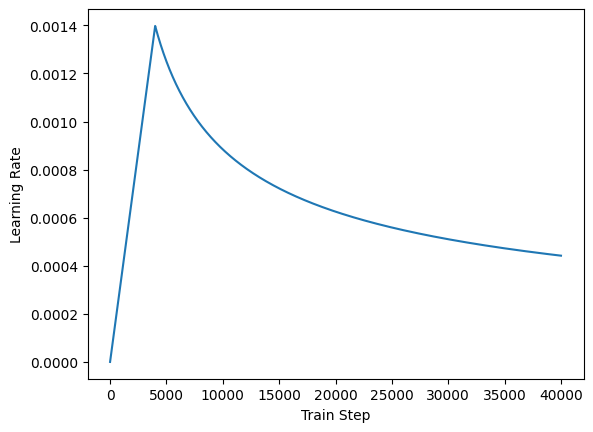

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

custom loss and accuracy

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape: (size, size)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)  # Mask for the encoder input
    dec_padding_mask = create_padding_mask(inp)  # Mask for the encoder input used in the decoder

    # Create a look-ahead mask for the target sequence
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])

    # Mask for the target sequence, combining look-ahead and padding mask
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Generate necessary masks
    enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        # Pass arguments as keyword arguments
        predictions, _ = transformer(
            inp=inp,  # input sequence
            tar=tar_inp,  # target sequence
            training=True,  # specify the training mode
            enc_padding_mask=enc_padding_mask,  # encoder padding mask
            dec_padding_mask=dec_padding_mask,  # decoder padding mask
            look_ahead_mask=look_ahead_mask  # look-ahead mask
        )

        # Calculate loss
        loss = loss_function(tar_real, predictions)

    # Compute gradients and update model weights
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update training metrics
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

training the model

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    # Reset metrics at the start of each epoch
    train_loss.reset_state()
    train_accuracy.reset_state()

    # Loop through each batch in the dataset
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)  # train_step will call create_masks internally

        if batch % 100 == 0:
            # Print batch-level training loss and accuracy every 100 batches
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

    # Print epoch-level training loss, accuracy, and time taken
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start} secs\n')


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['embeddings', 'embeddings', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 9.5247 Accuracy 0.0097
Epoch 1 Batch 100 Loss 7.9112 Accuracy 0.1011
Epoch 1 Batch 200 Loss 7.7988 Accuracy 0.1042
Epoch 1 Batch 300 Loss 7.7681 Accuracy 0.1038
Epoch 1 Batch 400 Loss 7.7491 Accuracy 0.1037
Epoch 1 Batch 500 Loss 7.7378 Accuracy 0.1038
Epoch 1 Batch 600 Loss 7.7174 Accuracy 0.1052
Epoch 1 Batch 700 Loss 7.7005 Accuracy 0.1066
Epoch 1 Batch 800 Loss 7.6800 Accuracy 0.1080
Epoch 1 Loss 7.6704 Accuracy 0.1087
Time taken for 1 epoch: 160.47065258026123 secs

Epoch 2 Batch 0 Loss 7.4747 Accuracy 0.1097
Epoch 2 Batch 100 Loss 7.3836 Accuracy 0.1171
Epoch 2 Batch 200 Loss 7.3809 Accuracy 0.1177
Epoch 2 Batch 300 Loss 7.3814 Accuracy 0.1180
Epoch 2 Batch 400 Loss 7.3738 Accuracy 0.1180
Epoch 2 Batch 500 Loss 7.3708 Accuracy 0.1181
Epoch 2 Batch 600 Loss 7.3701 Accuracy 0.1183
Epoch 2 Batch 700 Loss 7.3700 Accuracy 0.1183
Epoch 2 Batch 800 Loss 7.3670 Accuracy 0.1185
Epoch 2 Loss 7.3690 Accuracy 0.1186
Time taken for 1 epoch: 111.76013731956482 secs

Epoch 

evaluation

In [ ]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(encoder_input, output)

        # Call transformer without combined_mask if it's not expected
        predictions, attention_weights = transformer(
            encoder_input,
            output,
            training=False,  # Fix: passed as keyword argument
            enc_padding_mask=enc_padding_mask,
            dec_padding_mask=dec_padding_mask,
            look_ahead_mask=look_ahead_mask  # If combined_mask is not needed, leave it out
        )

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_article):
    input_article=preprocess(input_article)
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]

predictions

In [ ]:
article[16]

'<SOS> Smoking cannabis may double the risk of stress cardiomyopathy, a rare condition that temporarily weakens the heart, a US-based research has shown. The condition mimics the symptoms of cardiac arrest. Cannabis users experiencing an episode of stress cardiomyopathy are significantly more likely than non-users to go into cardiac arrest or need correction to abnormal heart rhythms, the study revealed. <EOS>'

In [ ]:
print("Real Headline : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Real Headline :   Cannabis smoking may double `rare heart condition risk`  
Predicted Summary :  cannabis smoking may double rare heart condition risk


In [ ]:
article[23]

'<SOS> Ratan Tata, Tata Sons interim Chairman, has reportedly written a letter to employees reassuring them about the future of the group and its companies. Further, he said that the decision to change the leadership at Tata Sons was a well-deliberated one taken to maintain the Tata culture. The letter comes a week after Tata chairman Cyrus Mistry was sacked. <EOS>'

In [ ]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Tata writes to employees reassuring them of group`s future  
Predicted Summary :  ratan tata writes to employees report


In [ ]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   US Marines stationed in Norway to train in winter warfare  
Predicted Summary :  us refuses to train chinese province to train in winter


In [ ]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Tata writes to employees reassuring them of group`s future  
Predicted Summary :  ratan tata writes to employees report


In [ ]:
summarize("Text Summarization - as the name suggests - involves generating short summaries of text data, in a few words or sentences. A good example of this in day-to-day life is the Inshorts news summary app, which generates summaries upto max of ~ 60 words.")

'the member is the pooh story in the life'

In [ ]:
summarize("""Cambodian leader Hun Sen on Friday rejected opposition parties' demands
for talks outside the country, accusing them of trying to ``internationalize''
the political crisis. Government and opposition parties have asked
King Norodom Sihanouk to host a summit meeting after a series of post-election
negotiations between the two opposition groups and Hun Sen's party
to form a new government failed. Opposition leaders Prince Norodom
Ranariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition
figures after two alleged attempts on his life, said they could not
negotiate freely in Cambodia and called for talks at Sihanouk's residence
in Beijing. Hun Sen, however, rejected that. ``I would like to make
it clear that all meetings related to Cambodian affairs must be conducted
in the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet
meeting on Friday. ``No-one should internationalize Cambodian affairs.
It is detrimental to the sovereignty of Cambodia,'' he said. Hun Sen's
Cambodian People's Party won 64 of the 122 parliamentary seats in
July's elections, short of the two-thirds majority needed to form
a government on its own. Ranariddh and Sam Rainsy have charged that
Hun Sen's victory in the elections was achieved through widespread
fraud. They have demanded a thorough investigation into their election
complaints as a precondition for their cooperation in getting the
national assembly moving and a new government formed. Hun Sen said
on Friday that the opposition concerns over their safety in the country
was ``just an excuse for them to stay abroad.'' Both Ranariddh and
Sam Rainsy have been outside the country since parliament was ceremonially
opened on Sep. 24. Sam Rainsy and a number of opposition figures have
been under court investigation for a grenade attack on Hun Sen's Phnom
Penh residence on Sep. 7. Hun Sen was not home at the time of the
attack, which was followed by a police crackdown on demonstrators
contesting Hun Sen's election victory. The Sam Rainsy Party, in a
statement released Friday, accused Hun Sen of being ``unwilling to
make any compromise'' on negotiations to break the deadlock. ``A meeting
outside Cambodia, as suggested by the opposition, could place all
parties on more equal footing,'' said the statement. ``But the ruling
party refuses to negotiate unless it is able to threaten its negotiating
partners with arrest or worse.'' """)

'cambodian opposition leader rejects alliance with decision'

In [ ]:
summarize("cambodian leader hun sen on friday rejected opposition parties ' demands for talks outside the country , accusing them of trying to `` internationalize '' the political crisis .")

'cambodian leader demands opposition demands opposition demands'

In [ ]:
summarize("king norodom sihanouk has declined requests to chair a summit of cambodia 's top political leaders , saying the meeting would not bring any progress in deadlocked negotiations to form a government .")

"italy's premier to not seek work to bring chair says cambodia"

In [ ]:
summarize("sometime in the summer of 1997 , an operative for osama bin laden sat down at his personal computer in a hideaway in kenya , he was worried , he wrote in an angry dispatch , about the security of the `` east africa network '' of bin laden , the saudi exile accused of masterminding a worldwide terrorist conspiracy against americans .")

'osama bin laden s and osama bin laden in africa'

In [ ]:
summarize("six months after president clinton traveled to beijing and challenged china 's leaders to move rapidly toward political reform , the administration 's policy of engaging beijing was called into question monday when chinese courts sentenced three of the nation 's most prominent dissidents to long jail sentences .")

'clinton backs beijing policy for political gimmick founder'

In [ ]:
summarize("fbi agents this week began questioning relatives of the victims of the aug. 7 u.s. embassy bombing as well as the seriously injured on request of the u.s. attorney 's office for the southern district of new york , a u.s. official said thursday .")

'fbi questions u s rights victims to support victims of u s embassy'

In [ ]:
summarize("Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.")

'11 yrs since university of artificial intelligence'

In [ ]:
summarize("Actor Ranbir Kapoor worked as an assistant director for Sanjay Leela Bhansali&#39;s &#39;Black&#39; in 2005. He is also known to have assisted in the making of the 1996 film &#39;PremGranth&#39; and his father Rishi Kapoor&#39;s directorial debut &#39;Aa Ab Laut Chalen&#39; in 1999. The actor, who has won five Filmfare awards including Best Actor for &#39;Barfi!&#39;, turned 34 on Wednesday.")

'ranbir kapoor worked as assistant director for black'

In [ ]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   US Marines stationed in Norway to train in winter warfare  
Predicted Summary :  us refuses to train chinese province to train in winter


In [ ]:
summarize("The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.")

'4 ex bank officials booked for cheating bank of cheating bank'